<a href="https://colab.research.google.com/github/suchirmm/tweet-analysis/blob/main/corona_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install langdetect
!pip install spacy

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 


import re
import nltk
# import langdetect 
import gensim
import gensim.downloader as gensim_api
import spacy


from sklearn.metrics import accuracy_score, auc, precision_score,\
recall_score, f1_score
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from textblob import TextBlob
from sklearn.model_selection import train_test_split

from textblob import TextBlob

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer



In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)


In [ ]:
link1 = '/content/drive/MyDrive/Corona_NLP_test.csv'
data_test = pd.read_csv(link1)
link2 = '/content/drive/MyDrive/Corona_NLP_train.csv'
data_train = pd.read_csv(link2, encoding = 'latin1')

In [ ]:
data_train.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive


In [ ]:
# perfrom NER on this 

data_train['Location'].sample(10)

38093                          NaN
24466                   Denver, CO
10433              London, England
10240                    London UK
34227    Adelaide, South Australia
23920                  Everywhere 
33546    Falls Church VA 22042 USA
20785                          NaN
7199                          Kent
35358                          NaN
Name: Location, dtype: object

In [ ]:
# More features than just the text

data_train.shape

(41157, 6)

In [ ]:
# Some null values
# Only for location 

data_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
data_train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
# Low importance feature
# Too many unique values

data_train['ScreenName'].nunique()

41157

In [ ]:
# Low importance feature
# Too many unique values

data_train['UserName'].nunique()

41157

## **Feature Engineering**

In [ ]:
# Drop features UserName, ScreenName
# They may have some information 
# Just not explored yet 

df = data_train.copy()
df.drop(['UserName', 'ScreenName'], axis = 1, inplace = True)
df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.dtypes

Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [ ]:
# Change the values of the Target Variable to numeric

df = df.replace({'Sentiment': {'Extremely Negative': -2 , 'Negative' :-1 ,
                              'Neutral' : 0, 'Positive' : 1, 'Extremely Positive' : 2 }

})

In [ ]:
df['Sentiment'].value_counts()

 1    11422
-1     9917
 0     7713
 2     6624
-2     5481
Name: Sentiment, dtype: int64

In [ ]:
# Changing TweetAt to datetime type

df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df.dtypes

Location                 object
TweetAt          datetime64[ns]
OriginalTweet            object
Sentiment                 int64
dtype: object

In [ ]:
# Verify if TweetAt has changed to the right format

df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,1
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,1
3,NaN,2020-03-16,My food stock is not the only one which is emp...,1
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",-2


In [ ]:
df['TweetAt'].dt.dayofweek.value_counts()

2    7440
1    6892
3    6234
4    6067
5    5916
0    5364
6    3244
Name: TweetAt, dtype: int64

In [ ]:
# Insert a month column - Feature creation from TweetAt
# Feature engineering

df.insert(2, 'Month', df['TweetAt'].dt.month, True)

df.head()

,Location,TweetAt,Month,OriginalTweet,Sentiment
0,London,2020-03-16,3,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,UK,2020-03-16,3,advice Talk to your neighbours family to excha...,1
2,Vagabonds,2020-03-16,3,Coronavirus Australia: Woolworths to give elde...,1
3,NaN,2020-03-16,3,My food stock is not the only one which is emp...,1
4,NaN,2020-03-16,3,"Me, ready to go at supermarket during the #COV...",-2


In [ ]:
# Insert more date-time based features

df.insert(3, 'Quarter', df['TweetAt'].dt.quarter, True)
df.insert(4, 'Year', df['TweetAt'].dt.year, True)
df.insert(5, 'DayOfWeek', df['TweetAt'].dt.dayofweek, True)

df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2


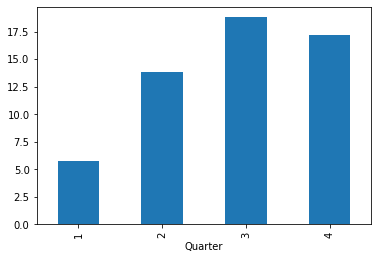

In [ ]:
# Sentiment analysis by quarter

round((df.groupby('Quarter')['Sentiment'].mean()*100),2).plot.bar()

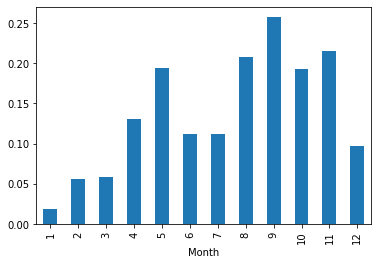

In [ ]:
# Sentiment analysis by month

df.groupby('Month')['Sentiment'].mean().plot.bar()

In [ ]:
df['Location'].value_counts()[:10]

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [ ]:
from nltk.tokenize import TweetTokenizer

In [ ]:
df['OriginalTweet_Len'] = df['OriginalTweet'].apply(len)
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310


In [ ]:
# To get the WordNetLemmatizer

import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=True, flg_lemm=False, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    tk = TweetTokenizer()
    lst_text = tk.tokenize(text)

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
sw = stopwords.words('english')
sw

df["txt"] = df["OriginalTweet"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords= sw))

In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv httpstcoifz 9fan2...
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...


In [ ]:
df['txt_len'] = df['txt'].apply(len)


In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv httpstcoifz 9fan2...,88
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,120
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,202
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,212


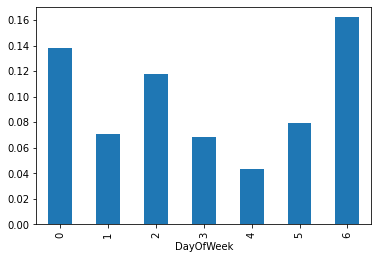

In [ ]:
# Day of the Week analysis

df.groupby('DayOfWeek')['Sentiment'].mean().plot.bar()

In [ ]:
# Various features can be created

'''
df['word_count'] = df["text"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["text"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']
df.head()

'''

'\ndf[\'word_count\'] = df["text"].apply(lambda x: len(str(x).split(" ")))\ndf[\'char_count\'] = df["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))\ndf[\'sentence_count\'] = df["text"].apply(lambda x: len(str(x).split(".")))\ndf[\'avg_word_length\'] = df[\'char_count\'] / df[\'word_count\']\ndf[\'avg_sentence_lenght\'] = df[\'word_count\'] / df[\'sentence_count\']\ndf.head()\n\n'

In [ ]:
df['Sentiment'].value_counts()

 1    11422
-1     9917
 0     7713
 2     6624
-2     5481
Name: Sentiment, dtype: int64

In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv httpstcoifz 9fan2...,88
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,120
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,202
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,212


In [ ]:
# Another way for text pre processing 

'''
import string
from nltk.corpus import stopwords

sw = stopwords.words('english')
print(sw)
print (string.punctuation)

def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

 # df['tokenized_tweet'] = df['OriginalTweet'].apply(text_process)

'''

"\nimport string\nfrom nltk.corpus import stopwords\n\nsw = stopwords.words('english')\nprint(sw)\nprint (string.punctuation)\n\ndef text_process(msg):\n    nopunc =[char for char in msg if char not in string.punctuation]\n    nopunc=''.join(nopunc)\n    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])\n\n # df['tokenized_tweet'] = df['OriginalTweet'].apply(text_process)\n\n"

## **NER**

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
'''
To get the Named Entity in the 
'''

def show_ents(data):
  doc = nlp(data)
  if doc.ents:
    for ent in doc.ents:
      # print(ent.text+' - ' +str(ent.start_char) +' - '+ str(ent.end_char) +' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_)))
      # print(ent.text+' - ' + ent.label_ + ' - '+str(spacy.explain(ent.label_)))
        return ent.label_
  else:
    # print('No named entities found.')
    return None

In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv httpstcoifz 9fan2...,88
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,120
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,202
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,212


In [ ]:
# Filling null values of 'Location' with placeholder null 

df['Location'] = df['Location'].fillna('none')
df.head()

In [ ]:
df['location_ner'] = df['Location'].apply(show_ents)

In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len,location_ner
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv httpstcoifz 9fan2...,88,GPE
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185,GPE
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,120,None
3,none,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,202,None
4,none,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,212,None


In [ ]:
# See the value_counts

from collections import Counter
Counter(df['location_ner'])

In [ ]:
# Most are showing locations 
# Need to see which ones can show countries

df['location_ner'].value_counts()

GPE            21209
ORG             3475
PERSON          1430
LOC              884
CARDINAL         272
NORP             169
DATE              60
FAC               30
MONEY             23
ORDINAL           16
PRODUCT           15
WORK_OF_ART       10
EVENT             10
QUANTITY           9
TIME               3
LANGUAGE           2
PERCENT            2
LAW                2
Name: location_ner, dtype: int64

In [ ]:
# Mostly are all are misclassified
# Those classified as 'ORG' seem to be genuine locations

df.loc[df['location_ner'] == 'ORG']

In [ ]:
# Some garbage
# But a lot of useful Locations have not had apt NER identification done on them 

df.loc[(df['location_ner'].isnull() == True) & (df['Location'] != 'none')]

In [ ]:
df['location_ner'].isnotnull().sum()

13536

## **LDA**

## **Data preparation + Model - LSTM**

In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv httpstcoifz 9fan2...,88
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,120
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,202
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,212


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

In [ ]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(df['txt'])

sequences = tokenizer.texts_to_sequences(df['txt'])
word_index = tokenizer.word_index
print('Found %s unqiue tokens' % len(word_index))

Found 91273 unqiue tokens


In [ ]:
word_index

In [ ]:
tokenizer = Tokenizer(num_words=10000, lower=True, split=' ')
tokenizer.fit_on_texts(df['txt'].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(df['txt'].values)
X = pad_sequences(X)

In [ ]:
X.shape

(41157, 41)

In [ ]:
embed_dim = 512
lstm_out = 200
batch_size = 128

model = Sequential()
model.add(Embedding(5000, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out , dropout = 0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 512)           2560000   
                                                                 
 lstm_4 (LSTM)               (None, 200)               570400    
                                                                 
 dense_4 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 3,131,405
Trainable params: 3,131,405
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)

#Here we train the Network.

model.fit(X_train, Y_train, batch_size =128, epochs = 10,  verbose = 5)

In [ ]:
score,acc = model.evaluate(X_valid, Y_valid, batch_size = 128, verbose = 2)

65/65 - 1s - loss: 1.4877 - accuracy: 0.6624 - 795ms/epoch - 12ms/step


In [ ]:
# only seem to be getting a 66% accuracy
# which is poor for a sentiment classification problem

print(score)
print(acc)



1.4877482652664185
0.6624149680137634


## **Data preparation - For logistic regression**

In [ ]:
df_test = data_test.copy()

In [ ]:
df_test["txt"] = df_test["OriginalTweet"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords= sw))
df_test.head()

In [ ]:
X_test = df_test.copy()

X_test.drop([col for col in X_test.columns if col not in ['txt', 'Sentiment']], axis = 1, inplace = True)

y_test = X_test.pop('Sentiment')

y_test = y_test.replace({'Extremely Negative':-2 ,'Negative': -1, 'Neutral':0,
                         'Positive':1, 'Extremely Positive' : 2
                         })


In [ ]:
X_train = df.copy()
X_train.drop([col for col in X_train.columns if col not in ['txt', 'Sentiment']], axis = 1, inplace = True)

y_train = X_train.pop('Sentiment')
X_train.head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 10)


In [ ]:
train_vectorized = vectorizer.fit_transform(X_train['txt'])
test_vectorized = vectorizer.transform(X_test['txt'])

In [ ]:
train_vectorized

In [ ]:
train_array= train_vectorized.toarray()
test_array = test_vectorized.toarray()

In [ ]:
print(train_array.shape)
print(test_array.shape)

## **Model-Logistic**

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True, max_iter=10000)
clf.fit(train_array, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
train_class_preds = clf.predict(train_array)
test_class_preds = clf.predict(test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


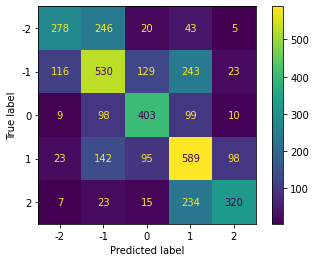

In [ ]:
plot_confusion_matrix(clf, test_array, y_test)

In [ ]:
f1_score(y_test, test_class_preds, average = None)

array([0.54243902, 0.50961538, 0.62919594, 0.54663573, 0.60663507])

In [ ]:
print(classification_report(y_test, test_class_preds), "\n")


              precision    recall  f1-score   support

          -2       0.64      0.47      0.54       592
          -1       0.51      0.51      0.51      1041
           0       0.61      0.65      0.63       619
           1       0.49      0.62      0.55       947
           2       0.70      0.53      0.61       599

    accuracy                           0.56      3798
   macro avg       0.59      0.56      0.57      3798
weighted avg       0.57      0.56      0.56      3798
 



## **Model - LSTM**

## **OOB sentiment classification**